# Posicionamento de Motes em Redes RPL-DODAG

Neste notebook apresentamos um modelo simplificado de uma rede utilizando o protocolo RPL com topologia DODAG, para mais detalhes sobre este modelo recomendamos verificar o repositório [RPL-Insights](https://github.com/JunioCesarFerreira/RPL-Insights). Além disso, ajustamos os algoritmos NSGA-II e NSGA-III implementados no notebook [multidimensional-nsga](multidimensional-nsga.ipynb) para o problema de posicionar os motes na rede de forma a otimizar os seguintes objetivos:
- Consumo de energia (minimizar)
- Latência de rede (minimizar)
- Volume total de dados (maximizar)
- Tempo de resposta (minimizar)
- Taxa de transferência (maximizar)

## Modelo de Rede DODAG

In [1]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class Node:
    def __init__(self, node_id, position, is_root=False, enable_log=False):
        self.node_id = node_id
        self.position = position
        self.is_root = is_root
        self.rank = 0 if is_root else float('inf')  # Rank inicial (0 para a raiz)
        self.parent = None
        self.neighbors = []
        self.energy_consumption = 0  # Energia consumida pelo nó
        self.data_transmitted = 0  # Volume de dados transmitidos
        self.response_time = 0  # Tempo de resposta
        self.throughput = 0  # Taxa de transferência
        self.enable_log = enable_log

    def receive_dio(self, sender):
        """Processa uma mensagem DIO de um vizinho."""
        new_rank = sender.rank + 1  # Métrica simples: número de saltos
        if new_rank < self.rank:  # Atualiza se o novo caminho for melhor
            self.rank = new_rank
            self.parent = sender
            if self.enable_log:
                print(f"Nó {self.node_id} atualizou seu Rank para {self.rank} (Pai: {sender.node_id})")
            # Atualiza métricas
            dist = self.network.distance(self, sender)
            if dist == 0:
                dist = 0.001
            self.energy_consumption += 0.01 + dist * 0.01 + random.uniform(0.01, 0.1)  # Consumo proporcional à distância
            self.response_time += 0.01 + random.uniform(0.01, 0.1)  # Tempo de resposta baseado na distância
            self.throughput += (1 - random.uniform(0.1, 1.0)) / dist  # Simula taxa de transferência
            self.data_transmitted += 32 - random.uniform(1, 8*dist / 100)   # Simula volume de dados transmitidos

class Network:
    def __init__(self, num_nodes, area_size, radius_of_reach, enable_log=False, enable_plot=False):
        self.nodes = []
        self.graph = nx.Graph()
        self.area_size = area_size
        self.num_nodes = num_nodes
        self.radius_of_reach = radius_of_reach
        self.total_energy_consumption = 0  # Energia total consumida pela rede
        self.total_data_transmitted = 0  # Volume total de dados transmitidos
        self.total_latency = 0  # Latência total da rede
        self.total_response_time = 0  # Tempo de resposta acumulado
        self.total_throughput = 0  # Taxa total de transferência
        self.enable_log = enable_log
        self.enable_plot = enable_plot

    def create_network(self, positions=None):
        """Cria nós e estabelece vizinhança com base na distância.
        :param positions: Lista opcional de posições cartesianas [(x1, y1), (x2, y2), ...].
        """
        if positions and len(positions) != self.num_nodes:
            raise ValueError("O número de posições fornecidas deve ser igual ao número de nós.")

        for i in range(self.num_nodes):
            if positions:
                position = positions[i]
            else:
                position = self.generate_valid_position_with_neighborwood(i)

            node = Node(node_id=i, position=position, is_root=(i == 0), enable_log=self.enable_log)
            node.network = self  # Referência à rede para cálculos
            self.nodes.append(node)
            self.graph.add_node(i, pos=node.position)

        # Estabelece conexões com base em distância
        for node in self.nodes:
            for neighbor in self.nodes:
                if node != neighbor and self.distance(node, neighbor) < self.radius_of_reach:
                    node.neighbors.append(neighbor)
                    self.graph.add_edge(node.node_id, neighbor.node_id)
                    
        if self.enable_plot:
            self.plot("Grafo conectado por alcance")

    def generate_valid_position_with_neighborwood(self, id):
        """Gera nó e garante que tenha vizinhos no raio de alcance."""
        position = (random.randint(0, self.area_size), random.randint(0, self.area_size))
        if id > 0:
            not_neighbor = True
            while not_neighbor:
                position = (random.randint(0, self.area_size), random.randint(0, self.area_size))
                node = Node(node_id=id, position=position, is_root=False)
                for n in self.nodes:
                    if self.distance(n, node) < self.radius_of_reach:
                        not_neighbor = False
                        break
        return position
    
    def distance(self, node_a, node_b):
        """Calcula a distância euclidiana entre dois nós."""
        x1, y1 = node_a.position
        x2, y2 = node_b.position
        return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5

    def propagate_dio(self):
        """Simula a propagação de mensagens DIO a partir da raiz."""
        queue = [self.nodes[0]]  # Começa com a raiz
        visited = set()  # Conjunto de nós visitados

        while queue:
            current = queue.pop(0)  # Retira o primeiro nó da fila
            if current.node_id in visited:
                continue  # Evita processar novamente

            visited.add(current.node_id)  # Marca o nó como visitado

            for neighbor in current.neighbors:
                if neighbor.node_id not in visited:  # Processa apenas não visitados
                    neighbor.receive_dio(current)
                    queue.append(neighbor)  # Adiciona à fila

        # Atualiza métricas globais da rede
        self.update_network_metrics()

    def update_network_metrics(self):
        """Atualiza métricas globais da rede."""
        self.total_energy_consumption = sum(node.energy_consumption for node in self.nodes)
        self.total_data_transmitted = sum(node.data_transmitted for node in self.nodes)
        self.total_latency = sum(random.uniform(0.8, 1.2) * self.distance(node, node.parent) for node in self.nodes if node.parent)
        self.total_response_time = sum(node.response_time for node in self.nodes)
        self.total_throughput = sum(node.throughput for node in self.nodes)

    def visualize(self):
        """Visualiza o DODAG como um digrafo com setas."""
        digraph = nx.DiGraph()  # Digrafo para representar o DODAG

        # Adiciona os nós e arestas dirigidas com base no parent
        for node in self.nodes:
            digraph.add_node(node.node_id, pos=node.position)
            if node.parent is not None:
                digraph.add_edge(node.node_id, node.parent.node_id)

        # Recupera as posições para a plotagem
        pos = nx.get_node_attributes(digraph, 'pos')

        # Verifica se o nó 0 existe no dicionário de posições
        if 0 in pos:
            center = pos[0] 
            circ = patches.Circle(
                center,        
                self.radius_of_reach,       
                fill=False,
                edgecolor='red',
                linestyle='--',
                linewidth=1
            )
            plt.gca().add_patch(circ)
            
        # Plota o digrafo com setas
        nx.draw(digraph, pos, with_labels=True, node_size=300, node_color='lightblue', arrows=True)
        
        # Ajusta a proporção dos eixos para que sejam iguais
        plt.gca().set_aspect("equal", adjustable="box")
        
        plt.title("DODAG Simulado")
        plt.show()

    def plot(self, title):
        """Auxiliar para plot de grafos"""
        pos = nx.get_node_attributes(self.graph, 'pos')
        nx.draw(self.graph, pos, with_labels=True, node_size=300, node_color='lightblue')
        plt.gca().set_aspect("equal", adjustable="box")
        plt.title(title)
        plt.show()

### Testes do Modelo

Nó 1 atualizou seu Rank para 1 (Pai: 0)
Nó 2 atualizou seu Rank para 1 (Pai: 0)
Nó 3 atualizou seu Rank para 1 (Pai: 0)
Nó 4 atualizou seu Rank para 1 (Pai: 0)


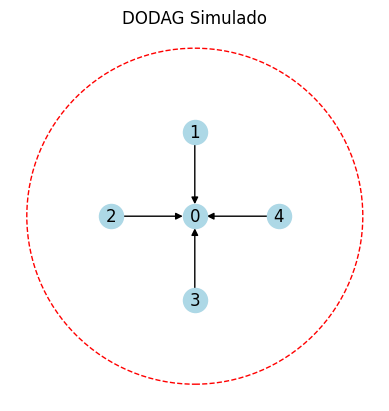

Consumo total de energia: 2.2003438830530113
Latência total da rede: 211.8370873613094
Volume total de dados transmitidos: 114.44657544812439
Tempo total de resposta: 0.2602902167541306
Taxa total de transferência: 0.023220228750524055


In [2]:
# Parâmetros da rede
NUM_NODES = 5
AREA_SIZE = 1000
RADIUS_OF_REACH = 100
pos = [(0,0),(0,50),(-50,0),(0,-50),(50,0)]

# Criação e simulação da rede
network = Network(NUM_NODES, AREA_SIZE, RADIUS_OF_REACH, enable_log=True)
network.create_network(positions=pos)
network.propagate_dio()
network.visualize()

# Exibe métricas globais da rede
print("Consumo total de energia:", network.total_energy_consumption)
print("Latência total da rede:", network.total_latency)
print("Volume total de dados transmitidos:", network.total_data_transmitted)
print("Tempo total de resposta:", network.total_response_time)
print("Taxa total de transferência:", network.total_throughput)

Nó 1 atualizou seu Rank para 1 (Pai: 0)
Nó 2 atualizou seu Rank para 1 (Pai: 0)
Nó 3 atualizou seu Rank para 1 (Pai: 0)
Nó 4 atualizou seu Rank para 1 (Pai: 0)


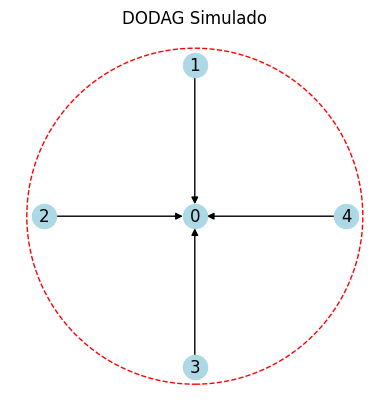

Consumo total de energia: 3.79976667058251
Latência total da rede: 371.96272124778244
Volume total de dados transmitidos: 113.00097572912686
Tempo total de resposta: 0.2843032078552336
Taxa total de transferência: 0.019934701164606924


In [3]:
pos = [(0,0),(0,90),(-90,0),(0,-90),(90,0)]

# Criação e simulação da rede
network = Network(NUM_NODES, AREA_SIZE, RADIUS_OF_REACH, enable_log=True)
network.create_network(positions=pos)
network.propagate_dio()
network.visualize()

# Exibe métricas globais da rede
print("Consumo total de energia:", network.total_energy_consumption)
print("Latência total da rede:", network.total_latency)
print("Volume total de dados transmitidos:", network.total_data_transmitted)
print("Tempo total de resposta:", network.total_response_time)
print("Taxa total de transferência:", network.total_throughput)

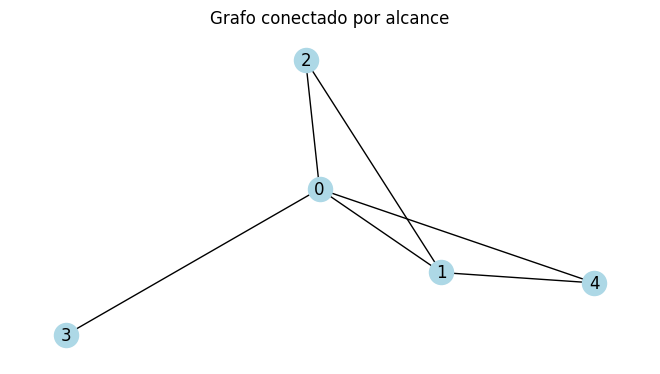

Nó 1 atualizou seu Rank para 1 (Pai: 0)
Nó 2 atualizou seu Rank para 1 (Pai: 0)
Nó 3 atualizou seu Rank para 1 (Pai: 0)
Nó 4 atualizou seu Rank para 1 (Pai: 0)


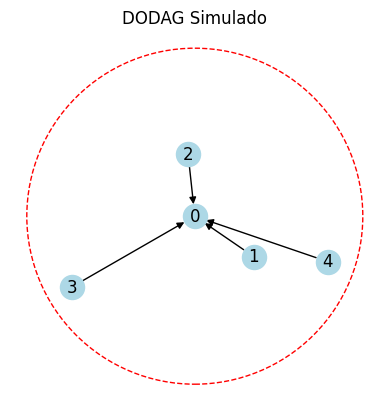

Consumo total de energia: 2.780438384375941
Latência total da rede: 246.49953246335923
Volume total de dados transmitidos: 113.78197848646428
Tempo total de resposta: 0.19974398622148587
Taxa total de transferência: 0.027587399326478714


In [4]:
# Criação e simulação da rede
network = Network(NUM_NODES, AREA_SIZE, RADIUS_OF_REACH, enable_log=True, enable_plot=True)
network.create_network()
network.propagate_dio()
network.visualize()

# Exibe métricas globais da rede
print("Consumo total de energia:", network.total_energy_consumption)
print("Latência total da rede:", network.total_latency)
print("Volume total de dados transmitidos:", network.total_data_transmitted)
print("Tempo total de resposta:", network.total_response_time)
print("Taxa total de transferência:", network.total_throughput)

## Função de Verificação de DODAG

A função `adjust_dodag` tem como objetivo verificar se um conjunto de pontos no plano formam uma rede DODAG (Directed Acyclic Graph) com o nó 0 como raiz. Se houver nós desconexos por caminhos no fluxo (isto é, que não conseguem alcançar a raiz), a função ajusta iterativamente suas posições para que passem a ter algum caminho até o nó 0. No final, a função retorna a lista de coordenadas (possivelmente modificadas) de maneira que todos os nós fiquem conectados dentro do raio fornecido.

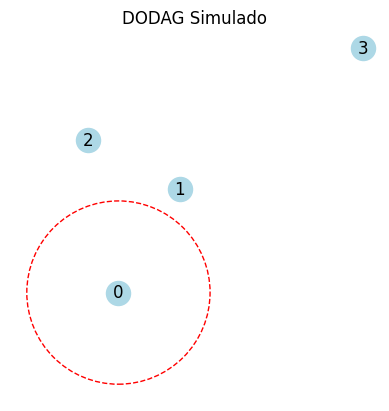

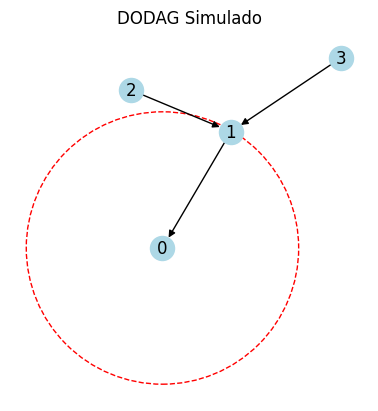

In [5]:
import numpy as np
from scipy.spatial.distance import cdist

def adjust_dodag(coords, radius, max_iterations=None, move_step=0.5, tol=1e-9):
    """
    Ajusta as coordenadas dos nós para formar uma rede DODAG (com nó 0 como raiz),
    garantindo que todos tenham caminho até a raiz dentro de um certo raio.

    Parâmetros:
        coords (list of tuple): Lista de coordenadas 2D [(x1, y1), (x2, y2), ...].
        radius (float): Raio de alcance para considerar dois nós conectados.
        max_iterations (int, opcional): Número máximo de iterações. Se None, usa 2*n.
        move_step (float, opcional): Fator de quanto o nó desconexo se move em direção
                                     ao nó mais próximo (0 < move_step <= 1).
                                     Se 1, move-se totalmente até ficar a (radius - 1)
                                     de distância do nó mais próximo.
                                     Se menor que 1, faz movimentos mais suaves.
        tol (float, opcional): Tolerância numérica para comparações de distância.

    Retorna:
        list: Lista de coordenadas ajustadas (como listas de floats).
    """
    # Conversão inicial
    coords = np.array(coords, dtype=float)
    n = len(coords)

    if max_iterations is None:
        max_iterations = 2 * n

    def get_connected_nodes(dist_matrix, radius):
        """
        Retorna uma lista booleana "connected" indicando, para cada nó,
        se ele é alcançável a partir do nó 0 via DFS, considerando
        distâncias <= radius (com tolerância).
        """
        visited = [False] * n

        def dfs(node):
            stack = [node]
            visited[node] = True
            while stack:
                curr = stack.pop()
                for neighbor in range(n):
                    # Verifica conexão com tolerância
                    if dist_matrix[curr][neighbor] <= radius + tol and not visited[neighbor]:
                        visited[neighbor] = True
                        stack.append(neighbor)

        # Inicia DFS a partir do nó 0
        dfs(0)
        return visited

    adjusted_coords = coords.copy()

    for _ in range(max_iterations):
        # 1. Calcula a matriz de distâncias apenas uma vez por iteração
        dist_matrix = cdist(adjusted_coords, adjusted_coords)

        # 2. Descobre quais nós estão conectados a partir da raiz
        connected = get_connected_nodes(dist_matrix, radius)

        # 3. Se todos estiverem conectados, encerra
        if all(connected):
            break

        # 4. Ajusta nós desconexos
        any_movement = False  # Para detectar se houve movimentação na iteração

        disconnected_nodes = [i for i in range(n) if not connected[i]]

        for i in disconnected_nodes:
            # Não permite mover a raiz (0)
            if i == 0: 
                continue

            # Escolhe o nó conectado mais próximo
            distances = dist_matrix[i]  # distância do nó i para todos
            # Ignora a si mesmo
            distances[i] = np.inf

            # Ignora outros nós desconexos, SE quisermos que somente nós conectados sejam alvo.
            # Descomente para proibir conexões entre nós desconexos:
            # for j in disconnected_nodes:
            #     distances[j] = np.inf

            # Verifica se existe algum nó conectado para nos aproximar
            connected_indices = [idx for idx, c in enumerate(connected) if c and idx != i]
            if not connected_indices:
                # Se nenhum nó está conectado (caso extremo), não há o que fazer.
                continue

            # Filtra distância somente para nós conectados
            for idx in range(n):
                if idx not in connected_indices:
                    distances[idx] = np.inf

            nearest_node = np.argmin(distances)
            dist_to_nearest = dist_matrix[i][nearest_node]

            # Se já estiver dentro do raio, não há necessidade de movimento
            if dist_to_nearest <= radius + tol:
                continue

            # Vetor do nó i para o nó mais próximo
            vector = adjusted_coords[nearest_node] - adjusted_coords[i]
            norm_vector = np.linalg.norm(vector)
            if norm_vector < tol:
                continue

            # Distância desejada é (radius - 1) para garantir alcance.
            desired_dist = max(radius - 1, 0) 
            delta = dist_to_nearest - desired_dist

            # Movimento será uma fração (move_step) do delta
            move_dist = move_step * delta

            # Vetor de movimento
            move_vector = (move_dist / norm_vector) * vector

            # Atualiza posição do nó i
            adjusted_coords[i] += move_vector
            any_movement = True

        # 5. Se não houve nenhuma movimentação nesta iteração, podemos encerrar
        if not any_movement:
            break

    return adjusted_coords.tolist()


# Exemplo de uso:
coords = [(0, 0), (2, 3.4), (-1, 5), (8, 8)]  # Coordenadas 2D
radius = 3  # Raio de alcance

network = Network(4, 10, radius)
network.create_network(positions=coords)
network.propagate_dio()
network.visualize()

result = adjust_dodag(coords, radius)

network = Network(4, 10, radius)
network.create_network(positions=result)
network.propagate_dio()
network.visualize()

## Algoritmos NSGA-II e NSGA-III adaptados para o problema RPL-DODAG

### Função de Incialização de População

In [6]:
# Inicialização da população
def initialize_population(size, num_nodes, area_size, radius_of_reach):
    population = []
    for _ in range(size):
        positions = []
        for i in range(num_nodes):
            valid_position = False
            while not valid_position:
                position = (random.randint(0, area_size), random.randint(0, area_size))
                valid_position = any(
                    ((position[0] - p[0])**2 + (position[1] - p[1])**2)**0.5 < radius_of_reach
                    for p in positions
                ) or len(positions) == 0
            positions.append(position)
        population.append(positions)
    return population

### Parâmetros para os Testes

In [7]:
# Parâmetros da rede
NUM_NODES = 31
AREA_SIZE = 1000
RADIUS_OF_REACH = 100

# Parâmetros para NSGAs
POP_SIZE=10
GENERATIONS=10

# População inicial
INIT_POP = initialize_population(POP_SIZE, NUM_NODES, AREA_SIZE, RADIUS_OF_REACH)

#### População Inicial

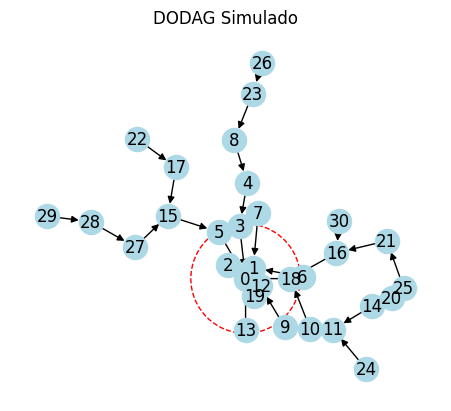

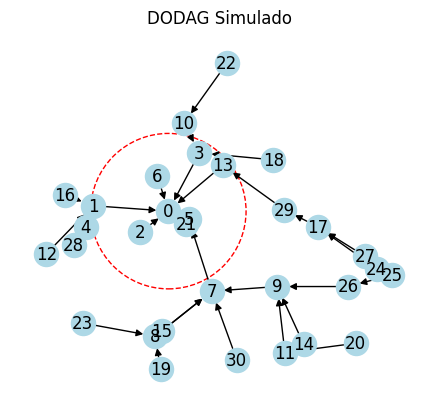

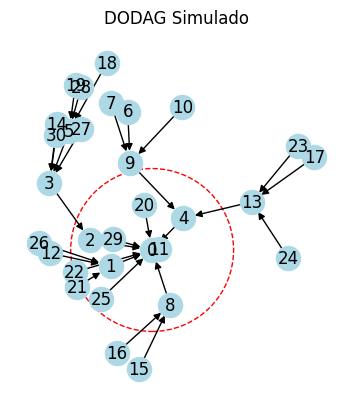

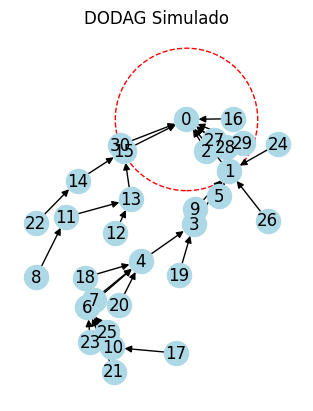

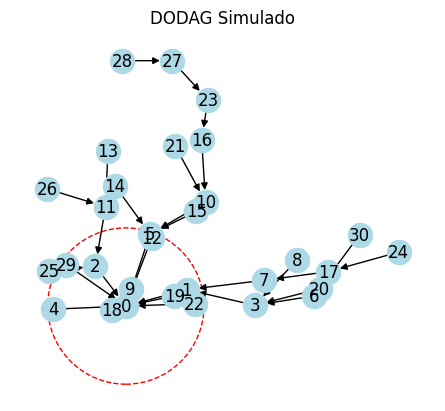

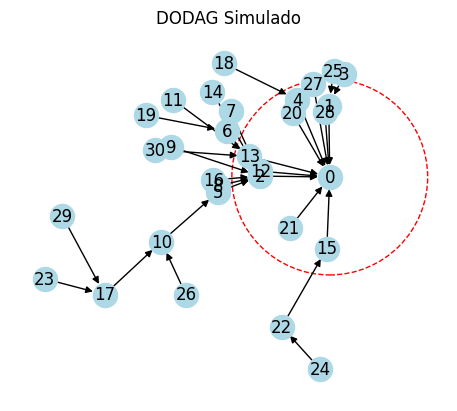

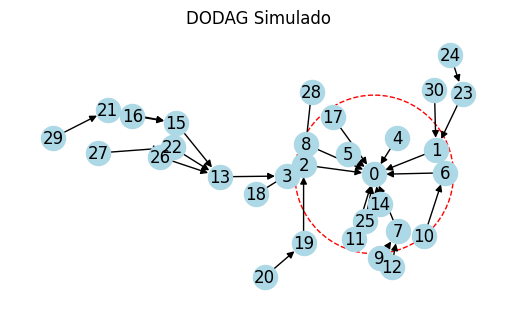

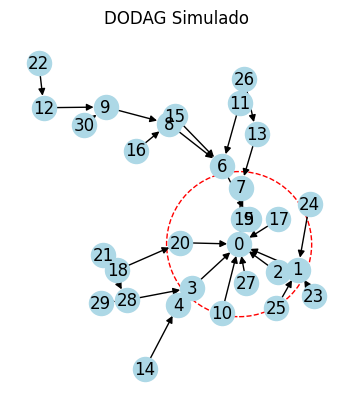

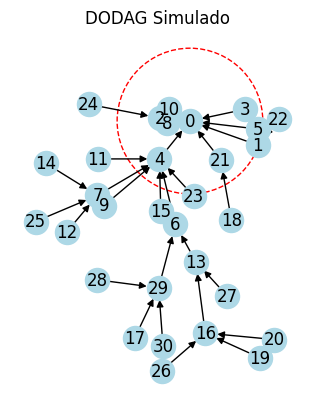

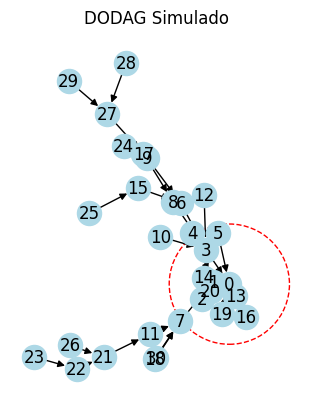

In [8]:
for pos in INIT_POP:
    # Criação e simulação da rede
    network = Network(NUM_NODES, AREA_SIZE, RADIUS_OF_REACH)
    network.create_network(positions=pos)
    network.propagate_dio()
    network.visualize()

### NSGA-II

In [9]:
def nsga2(pop_size, generations, network, init_population):
    """
    NSGA-II adaptado para operar em populações de posições.

    :param pop_size: Tamanho da população
    :param generations: Número de gerações
    :param network: Instância da classe Network
    """
    num_nodes = network.num_nodes
    area_size = network.area_size
    radius_of_reach = network.radius_of_reach

    # Avaliação da população
    def evaluate_population(population):
        metrics = []
        for positions in population:
            temp_network = Network(num_nodes, area_size, radius_of_reach)
            temp_network.create_network(positions=positions)
            temp_network.propagate_dio()
            metrics.append((
                temp_network.total_energy_consumption,
                temp_network.total_latency,
                -temp_network.total_data_transmitted,  # Negativo para maximizar
                temp_network.total_response_time,
                -temp_network.total_throughput  # Negativo para maximizar
            ))
        return metrics

    # Dominância
    def dominates(obj1, obj2):
        return all(x <= y for x, y in zip(obj1, obj2)) and any(x < y for x, y in zip(obj1, obj2))

    # Ordenação não-dominada
    def fast_nondominated_sort(objectives):
        fronts = [[]]
        domination_count = [0] * len(objectives)
        dominated_solutions = [[] for _ in range(len(objectives))]

        for p in range(len(objectives)):
            for q in range(len(objectives)):
                if dominates(objectives[p], objectives[q]):
                    dominated_solutions[p].append(q)
                elif dominates(objectives[q], objectives[p]):
                    domination_count[p] += 1

            if domination_count[p] == 0:
                fronts[0].append(p)

        i = 0
        while len(fronts[i]) > 0:
            next_front = []
            for p in fronts[i]:
                for q in dominated_solutions[p]:
                    domination_count[q] -= 1
                    if domination_count[q] == 0:
                        next_front.append(q)
            i += 1
            fronts.append(next_front)

        fronts.pop()
        return fronts

    # Cruzamento
    def crossover(parent1, parent2):
        return [
            ((p1[0] + p2[0]) // 2, (p1[1] + p2[1]) // 2)
            for p1, p2 in zip(parent1, parent2)
        ]

    # Mutação
    def mutation(individual, mutation_rate=0.1):
        for i in range(len(individual)):
            if random.random() < mutation_rate:
                valid_position = False
                while not valid_position:
                    new_position = (
                        random.randint(0, area_size),
                        random.randint(0, area_size)
                    )
                    valid_position = any(
                        ((new_position[0] - p[0])**2 + (new_position[1] - p[1])**2)**0.5 < radius_of_reach
                        for p in individual if p != individual[i]
                    )
                individual[i] = new_position
        return individual

    # Distância de crowding
    def crowding_distance(front, objectives):
        if len(front) == 1:
            return [float('inf')]
        
        distances = [0] * len(front)
        for m in range(len(objectives[0])):
            sorted_front = sorted(range(len(front)), key=lambda i: objectives[front[i]][m])
            distances[sorted_front[0]] = distances[sorted_front[-1]] = float('inf')
            for i in range(1, len(front) - 1):
                distances[sorted_front[i]] += (
                    objectives[front[sorted_front[i + 1]]][m] - objectives[front[sorted_front[i - 1]]][m]
                )
        return distances

    # Seleção com elitismo e validação de DODAG
    def select_next_population(fronts, objectives, population, pop_size):
        next_population = []
        for front in fronts:
            if len(next_population) + len(front) <= pop_size:
                next_population.extend(front)
            else:
                distances = crowding_distance(front, objectives)
                sorted_front = sorted(zip(front, distances), key=lambda x: x[1], reverse=True)
                next_population.extend([solution for solution, _ in sorted_front[:pop_size - len(next_population)]])
                break
        return [adjust_dodag(population[i], radius_of_reach) for i in next_population]  # Seleciona os indivíduos correspondentes

    # Inicializa a população
    population = init_population.copy()

    for gen in range(generations):
        objectives = evaluate_population(population)
        fronts = fast_nondominated_sort(objectives)

        new_population = []
        while len(new_population) < pop_size:
            parent1, parent2 = random.sample(population, 2)
            child = crossover(parent1, parent2)
            child = mutation(child)
            new_population.append(child)
            
        # Combinar pais e descendentes
        combined_population = population + new_population
        combined_objectives = evaluate_population(combined_population)
        
        # Realizar nova ordenação não-dominada
        combined_fronts = fast_nondominated_sort(combined_objectives)
        
        # Selecionar próxima geração com elitismo
        population = select_next_population(combined_fronts, combined_objectives, combined_population, pop_size)

    objectives = evaluate_population(population)
    fronts = fast_nondominated_sort(objectives)
    pareto_front = [population[i] for i in fronts[0]]
    return pareto_front

### NSGA-III

In [10]:
import random
import numpy as np
from collections import defaultdict

def nsga3(pop_size, generations, network, init_population, base_mutation_rate=0.1, divisions=4):
    """
    NSGA-III adaptado para operar em populações de posições.

    :param pop_size: Tamanho da população
    :param generations: Número de gerações
    :param network: Instância da classe Network
    :param base_mutation_rate: Taxa de mutação base
    :param divisions: Número de divisões para geração dos pontos de referência
    """
    num_nodes = network.num_nodes
    area_size = network.area_size
    radius_of_reach = network.radius_of_reach

    # Avaliação da população
    def evaluate_population(population):
        metrics = []
        for positions in population:
            temp_network = Network(num_nodes, area_size, radius_of_reach)
            temp_network.create_network(positions=positions)
            temp_network.propagate_dio()
            metrics.append((
                temp_network.total_energy_consumption,
                temp_network.total_latency,
                -temp_network.total_data_transmitted,  # Negativo para maximizar
                temp_network.total_response_time,
                -temp_network.total_throughput  # Negativo para maximizar
            ))
        return metrics

    # Dominância
    def dominates(obj1, obj2):
        return all(x <= y for x, y in zip(obj1, obj2)) and any(x < y for x, y in zip(obj1, obj2))

    # Ordenação não-dominada
    def fast_nondominated_sort(objectives):
        population_size = len(objectives)
        S = [[] for _ in range(population_size)]
        n = [0] * population_size
        rank = [0] * population_size
        fronts = [[]]

        for p in range(population_size):
            for q in range(population_size):
                if dominates(objectives[p], objectives[q]):
                    S[p].append(q)
                elif dominates(objectives[q], objectives[p]):
                    n[p] += 1
            if n[p] == 0:
                rank[p] = 0
                fronts[0].append(p)

        i = 0
        while fronts[i]:
            next_front = []
            for p in fronts[i]:
                for q in S[p]:
                    n[q] -= 1
                    if n[q] == 0:
                        rank[q] = i + 1
                        next_front.append(q)
            i += 1
            fronts.append(next_front)
        fronts.pop()
        return fronts

    # Geração de pontos de referência
    def generate_reference_points(M, p):
        def generate_recursive(points, num_objs, left, total, depth, current_point):
            if depth == num_objs - 1:
                current_point.append(left / total)
                points.append(current_point.copy())
                current_point.pop()
            else:
                for i in range(left + 1):
                    current_point.append(i / total)
                    generate_recursive(points, num_objs, left - i, total, depth + 1, current_point)
                    current_point.pop()
        points = []
        generate_recursive(points, M, p, p, 0, [])
        return np.array(points)

    # Seleção ambiental
    def environmental_selection(population, objectives, fronts, reference_points, pop_size):
        next_population_indices = []
        for front in fronts:
            if len(next_population_indices) + len(front) <= pop_size:
                next_population_indices.extend(front)
            else:
                N = pop_size - len(next_population_indices)
                selected_indices = niching_selection(front, objectives, reference_points, N)
                next_population_indices.extend(selected_indices)
                break
        next_population = [adjust_dodag(population[i], radius_of_reach) for i in next_population_indices]
        return next_population

    # Seleção por nicho
    def niching_selection(front, objectives, reference_points, N):
        selected = []
        objs = np.array([objectives[i] for i in front])
        ideal_point = np.min(objs, axis=0)
        normalized_objs = objs - ideal_point

        max_values = np.max(normalized_objs, axis=0)
        max_values[max_values == 0] = 1
        normalized_objs = normalized_objs / max_values

        associations = []
        for idx, obj in zip(front, normalized_objs):
            distances = np.linalg.norm(obj - reference_points, axis=1)
            min_index = np.argmin(distances)
            associations.append((idx, min_index, distances[min_index]))

        reference_associations = defaultdict(list)
        for idx, ref_idx, dist in associations:
            reference_associations[ref_idx].append((idx, dist))

        niche_counts = {i: 0 for i in range(len(reference_points))}
        selected_flags = {idx: False for idx in front}

        while len(selected) < N:
            min_niche_count = min(niche_counts.values())
            min_refs = [ref for ref, count in niche_counts.items() if count == min_niche_count]

            for ref_idx in min_refs:
                assoc_inds = reference_associations.get(ref_idx, [])
                unselected_inds = [(idx, dist) for idx, dist in assoc_inds if not selected_flags[idx]]

                if unselected_inds:
                    unselected_inds.sort(key=lambda x: x[1])
                    selected_idx = unselected_inds[0][0]
                    selected.append(selected_idx)
                    selected_flags[selected_idx] = True
                    niche_counts[ref_idx] += 1
                    break
            else:
                remaining = [idx for idx in front if not selected_flags[idx]]
                if remaining:
                    selected_idx = random.choice(remaining)
                    selected.append(selected_idx)
                    selected_flags[selected_idx] = True
                else:
                    break

        return selected[:N]

    # Inicializa a população
    population = init_population.copy()
    
    M = 5  # Número de objetivos
    reference_points = generate_reference_points(M, divisions)

    for gen in range(generations):
        objectives = evaluate_population(population)
        fronts = fast_nondominated_sort(objectives)

        offspring_population = []
        while len(offspring_population) < pop_size:
            parent1, parent2 = random.sample(population, 2)
            child = [
                ((p1[0] + p2[0]) // 2, (p1[1] + p2[1]) // 2)
                for p1, p2 in zip(parent1, parent2)
            ]
            mutation_rate = base_mutation_rate * (1 - gen / generations)
            child = [
                (
                    random.randint(0, area_size), random.randint(0, area_size)
                ) if random.random() < mutation_rate else p for p in child
            ]
            offspring_population.append(child)

        combined_population = population + offspring_population
        combined_objectives = evaluate_population(combined_population)
        combined_fronts = fast_nondominated_sort(combined_objectives)
        population = environmental_selection(combined_population, combined_objectives, combined_fronts, reference_points, pop_size)

    objectives = evaluate_population(population)
    fronts = fast_nondominated_sort(objectives)
    pareto_front = [population[i] for i in fronts[0]]
    
    return pareto_front

## Funções de visualização de resultados

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_table(df):
    # Configurar o estilo do plot
    plt.figure(figsize=(12, 4))
    plt.axis('off')
    table = plt.table(
        cellText=df.values,
        colLabels=df.columns,
        cellLoc='center',
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(df.columns))))

    plt.title("Tabela de Métricas das Soluções Pareto", fontsize=14, pad=20)
    plt.show()


In [12]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_solutions(df):
    """
    Gera um gráfico para N objetivos a partir de um DataFrame, normalizando as soluções e exibindo os valores.

    :param df: DataFrame contendo as métricas das soluções, onde cada coluna é um objetivo.
    """
    def normalize(df):
        """Normaliza os valores dos objetivos para o intervalo [0, 1]."""
        return (df - df.min()) / (df.max() - df.min())

    # Normalizar os valores do DataFrame
    normalized_df = normalize(df)

    # Configuração do gráfico
    num_objectives = normalized_df.shape[1]
    plt.figure(figsize=(14, 6))

    # Plot das soluções normalizadas
    for _, row in normalized_df.iterrows():
        plt.plot(row.index, row.values, marker='o', alpha=0.7)

    # Configurações do eixo
    plt.xticks(range(num_objectives), normalized_df.columns, rotation=45)
    plt.xlabel("Objetivos")
    plt.ylabel("Valores Normalizados")
    plt.title("Conjunto de Soluções Normalizadas para N Objetivos")
    plt.grid(alpha=0.3)

    # Ajustar layout e exibir
    plt.tight_layout()
    plt.show()


## Teste NSGA-II

Soluções Pareto:


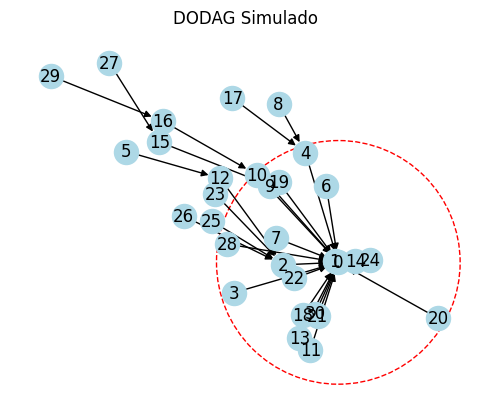

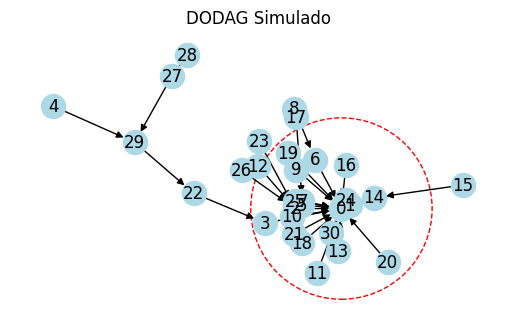

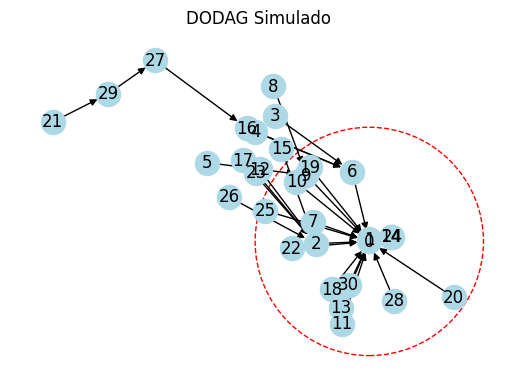

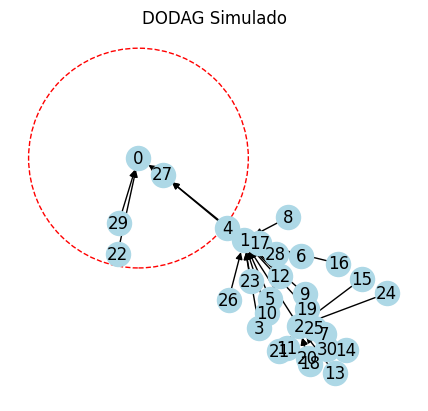

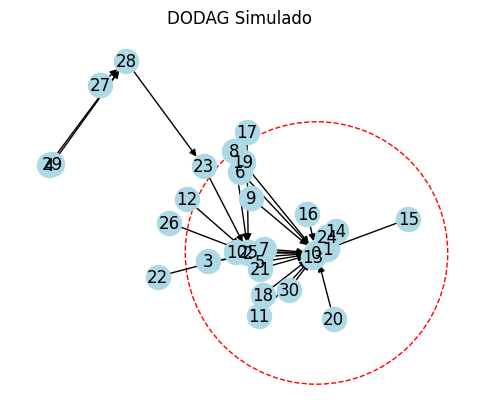

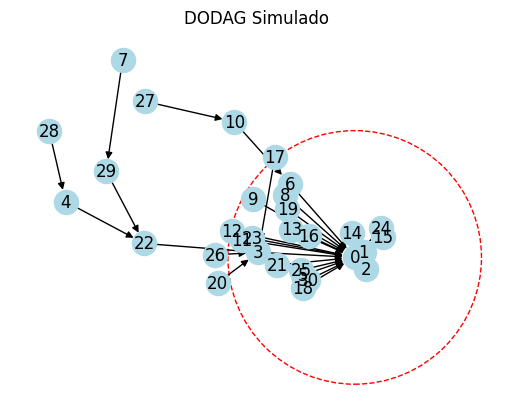

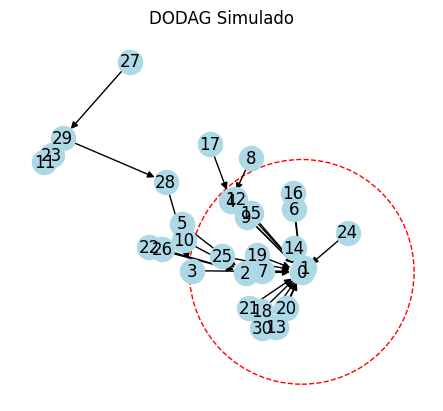

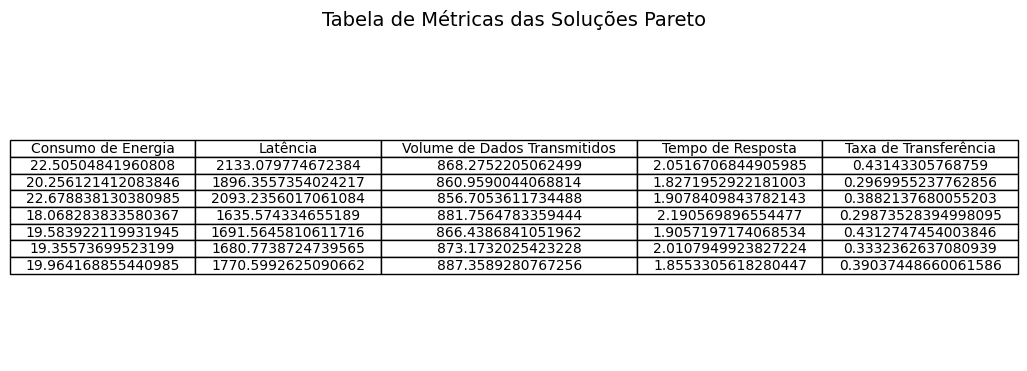

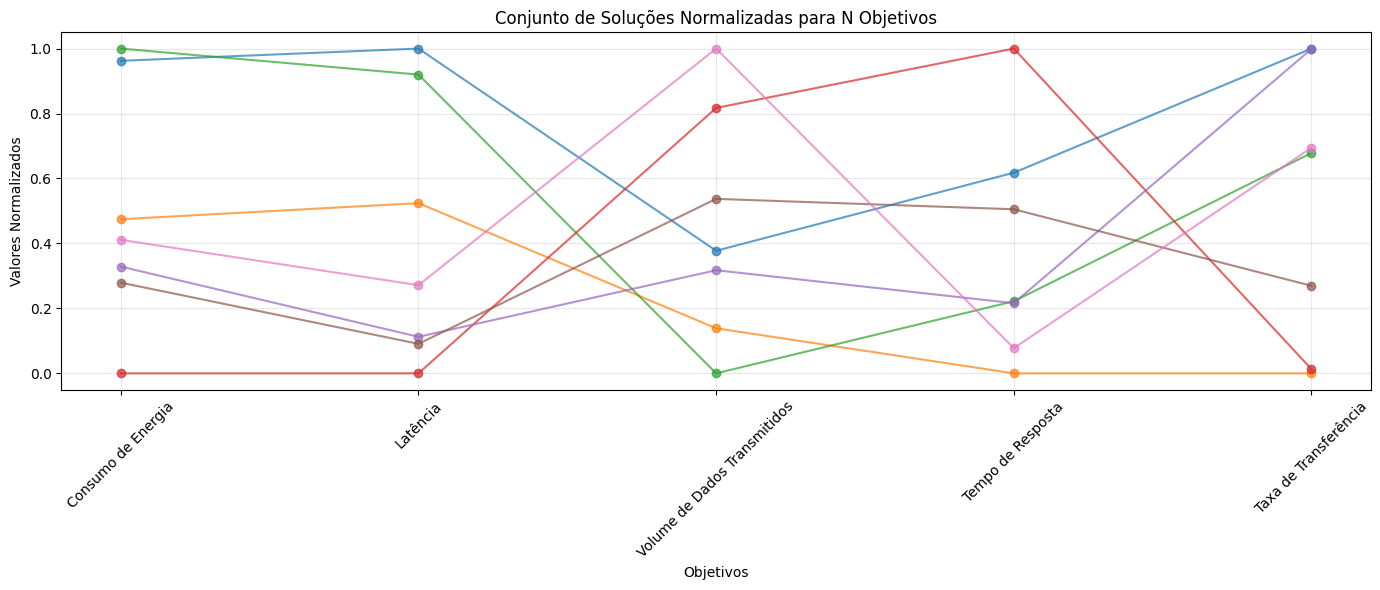

In [13]:
import pandas as pd

# Cria nova instância de rede
network = Network(NUM_NODES, AREA_SIZE, RADIUS_OF_REACH)

# Executa NSGA-II
pareto_solutions = nsga2(POP_SIZE, GENERATIONS, network, INIT_POP)
print("Soluções Pareto:")

data = []  # Lista para armazenar os dados para a tabela

for pos in pareto_solutions:
    # Criação e simulação da rede
    network = Network(NUM_NODES, AREA_SIZE, RADIUS_OF_REACH)
    network.create_network(positions=pos)
    network.propagate_dio()
    network.visualize()

    # Coleta das métricas globais
    metrics = {
        "Consumo de Energia": network.total_energy_consumption,
        "Latência": network.total_latency,
        "Volume de Dados Transmitidos": network.total_data_transmitted,
        "Tempo de Resposta": network.total_response_time,
        "Taxa de Transferência": network.total_throughput,
    }
    data.append(metrics)

# Cria um DataFrame a partir dos dados coletados
df2 = pd.DataFrame(data)

plot_table(df2)

plot_solutions(df2)

## Teste NSGA-III

Soluções Pareto:


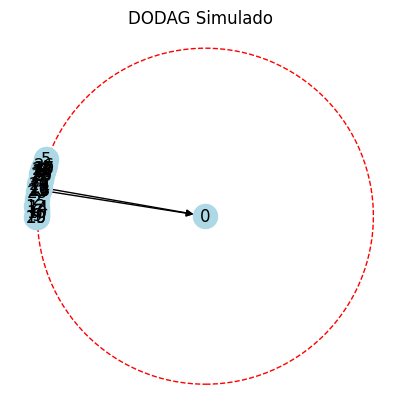

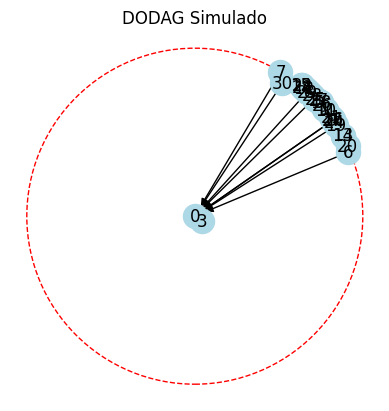

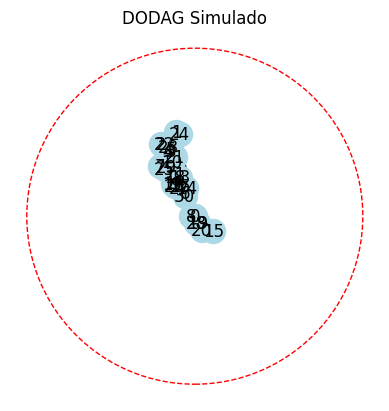

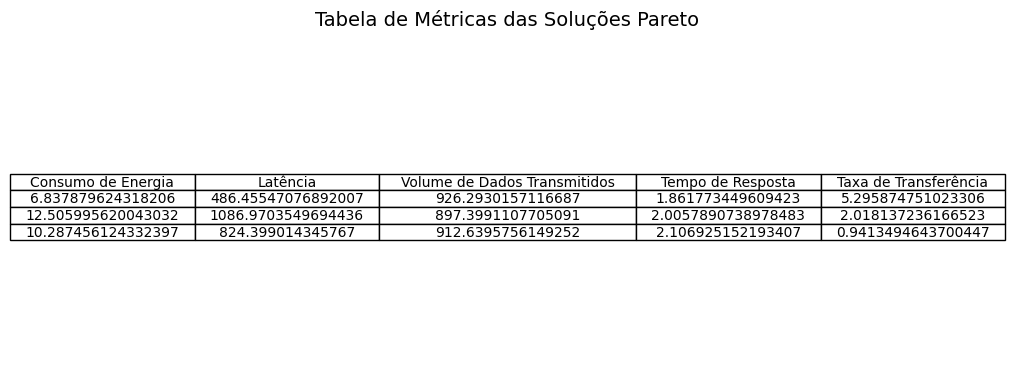

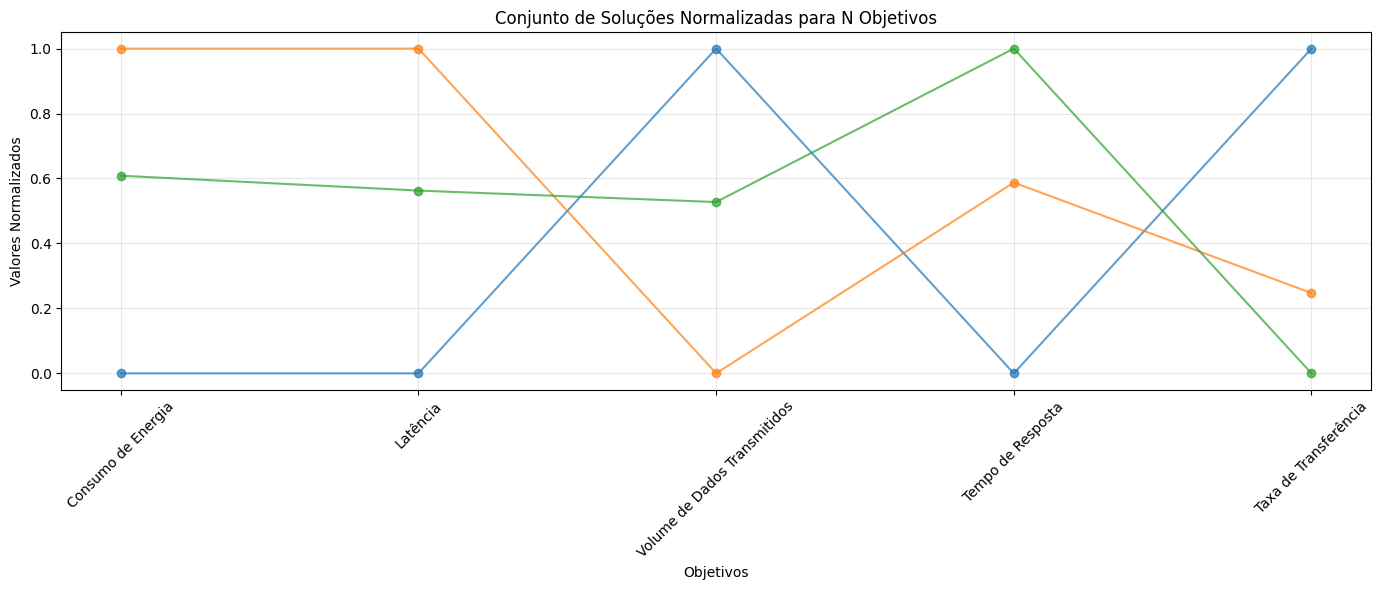

In [14]:
# Cria nova instância de rede
network = Network(NUM_NODES, AREA_SIZE, RADIUS_OF_REACH)

# Executa NSGA-II
pareto_solutions = nsga3(POP_SIZE, GENERATIONS, network, INIT_POP)
print("Soluções Pareto:")

data = []  # Lista para armazenar os dados para a tabela

for pos in pareto_solutions:
    # Criação e simulação da rede
    network = Network(NUM_NODES, AREA_SIZE, RADIUS_OF_REACH)
    network.create_network(positions=pos)
    network.propagate_dio()
    network.visualize()

    # Coleta das métricas globais
    metrics = {
        "Consumo de Energia": network.total_energy_consumption,
        "Latência": network.total_latency,
        "Volume de Dados Transmitidos": network.total_data_transmitted,
        "Tempo de Resposta": network.total_response_time,
        "Taxa de Transferência": network.total_throughput,
    }
    data.append(metrics)

# Cria um DataFrame a partir dos dados coletados
df3 = pd.DataFrame(data)

plot_table(df3)

plot_solutions(df3)

## Comparações de Resultados

Para efeitos de comparações incluímos alguns resultados adicionais conforme visto a seguir.

### Posicionamento utilizando Padrão Geométrico

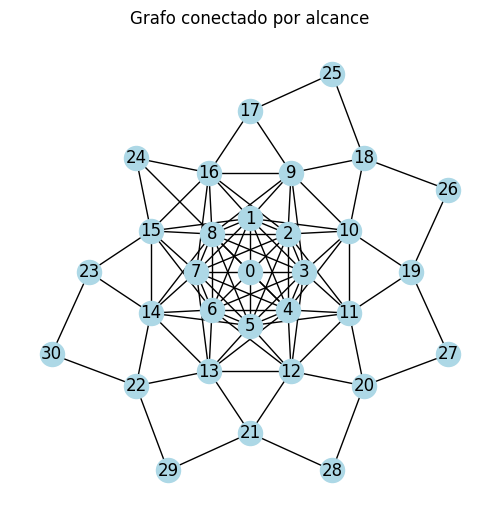

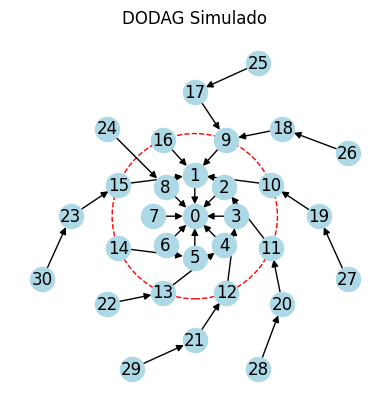

Consumo total de energia: 23.398844493958944
Latência total da rede: 2102.187455603997
Volume total de dados transmitidos: 858.6348666953854
Tempo total de resposta: 1.9664215235293425
Taxa total de transferência: 0.1839274372814621


In [15]:
import math

def generate_positions(k, theta, n):
    """
    Gera uma lista de pontos no plano conforme a regra descrita.

    Args:
        k (float): Multiplicador de escala.
        theta (float): Incremento do ângulo em radianos.
        n (int): Número total de pontos a serem gerados.

    Returns:
        list of tuple: Lista de pontos no plano [(x1, y1), (x2, y2), ...].
    """
    points = [(0, 0)]  # Primeiro ponto na origem
    phi = 0  # Inicialização do ângulo
    i = 1    # Inicialização do multiplicador radial

    for _ in range(1, n):  # Já temos o primeiro ponto, então iteramos de 1 até n-1
        x = i * k * math.sin(phi)
        y = i * k * math.cos(phi)
        points.append((x, y))

        phi += theta
        if phi >= 2 * math.pi:
            i += 1  # Incrementa o índice radial
            if i % 2 == 0:
                phi = theta/2
            else:
                phi = 0

    return points

# Exemplo de uso
k = 0.5 * RADIUS_OF_REACH
theta = math.pi / 4  
generated_points = generate_positions(k, theta, NUM_NODES)

# Criação e simulação da rede
network_geo = Network(NUM_NODES, AREA_SIZE, RADIUS_OF_REACH, enable_plot=True)
network_geo.create_network(positions=generated_points)
network_geo.propagate_dio()
network_geo.visualize()

# Exibe métricas globais da rede
print("Consumo total de energia:", network_geo.total_energy_consumption)
print("Latência total da rede:", network_geo.total_latency)
print("Volume total de dados transmitidos:", network_geo.total_data_transmitted)
print("Tempo total de resposta:", network_geo.total_response_time)
print("Taxa total de transferência:", network_geo.total_throughput)


### Posicionamento Aleatório

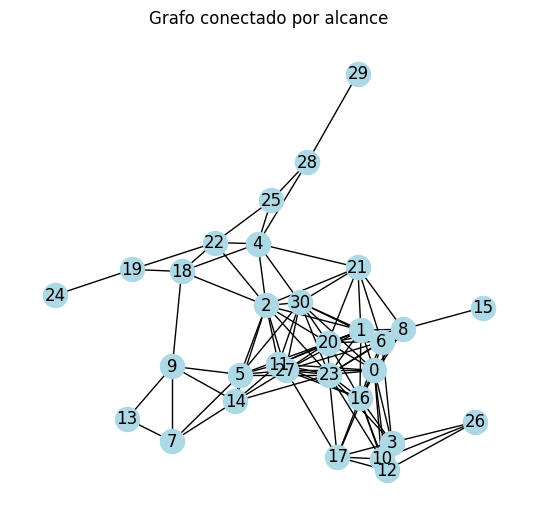

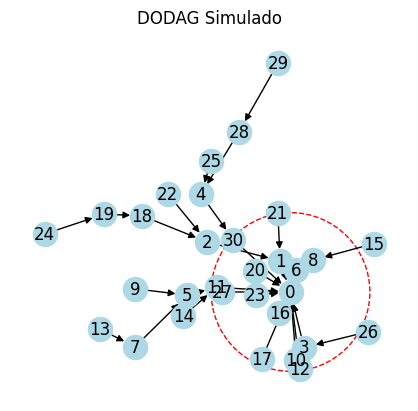

Consumo total de energia: 22.73697351599135
Latência total da rede: 2068.3025167706296
Volume total de dados transmitidos: 869.9084286684092
Tempo total de resposta: 1.980634362912025
Taxa total de transferência: 0.19578332365354748


In [16]:
# Criação e simulação da rede
network_rand = Network(NUM_NODES, AREA_SIZE, RADIUS_OF_REACH, enable_plot=True)
network_rand.create_network()
network_rand.propagate_dio()
network_rand.visualize()

# Exibe métricas globais da rede
print("Consumo total de energia:", network_rand.total_energy_consumption)
print("Latência total da rede:", network_rand.total_latency)
print("Volume total de dados transmitidos:", network_rand.total_data_transmitted)
print("Tempo total de resposta:", network_rand.total_response_time)
print("Taxa total de transferência:", network_rand.total_throughput)

### Comparando os Resultados

#### Função de Plotagem

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_solutions2(df2, df3, geo, rand):
    """
    Plota os dados de dois DataFrames e dois vetores (geo e rand) com normalização.

    Args:
        df2 (pd.DataFrame): Primeiro DataFrame com soluções.
        df3 (pd.DataFrame): Segundo DataFrame com soluções.
        geo (list): Lista representando uma linha específica a ser plotada.
        rand (list): Lista representando outra linha específica a ser plotada.

    Returns:
        None
    """
    # Concatenar dados para normalização
    all_data = pd.concat([df2, df3, pd.DataFrame([geo], columns=df2.columns), pd.DataFrame([rand], columns=df2.columns)])

    # Normalizar os dados
    normalized_data = (all_data - all_data.min()) / (all_data.max() - all_data.min())

    # Extrair os dados normalizados de volta
    df2_normalized = normalized_data.iloc[:len(df2)]
    df3_normalized = normalized_data.iloc[len(df2):len(df2) + len(df3)]
    geo_normalized = normalized_data.iloc[len(df2) + len(df3)].values
    rand_normalized = normalized_data.iloc[len(df2) + len(df3) + 1].values

    # Configuração do gráfico
    num_objectives = df2.shape[1]
    plt.figure(figsize=(14, 6))

    # Plot das soluções normalizadas para df2
    for _, row in df2_normalized.iterrows():
        plt.plot(row.index, row.values, marker='o', alpha=0.7, label="NSGA-2" if _ == 0 else "")

    # Plot das soluções normalizadas para df3
    for _, row in df3_normalized.iterrows():
        plt.plot(row.index, row.values, marker='s', alpha=0.7, label="NSGA-3" if _ == 0 else "")

    # Plot do vetor geo normalizado
    plt.plot(df2.columns, geo_normalized, marker='d', alpha=1.0, color='green', linewidth=2, label="Geo")

    # Plot do vetor rand normalizado
    plt.plot(df2.columns, rand_normalized, marker='x', alpha=1.0, color='red', linewidth=2, label="Rand")

    # Configurações do eixo
    plt.xticks(range(num_objectives), df2.columns, rotation=45)
    plt.xlabel("Objetivos")
    plt.ylabel("Valores Normalizados")
    plt.title("Conjunto de Soluções Normalizadas para N Objetivos")
    plt.grid(alpha=0.3)
    plt.legend()

    # Ajustar layout e exibir
    plt.tight_layout()
    plt.show()

#### Resultados Comparativos

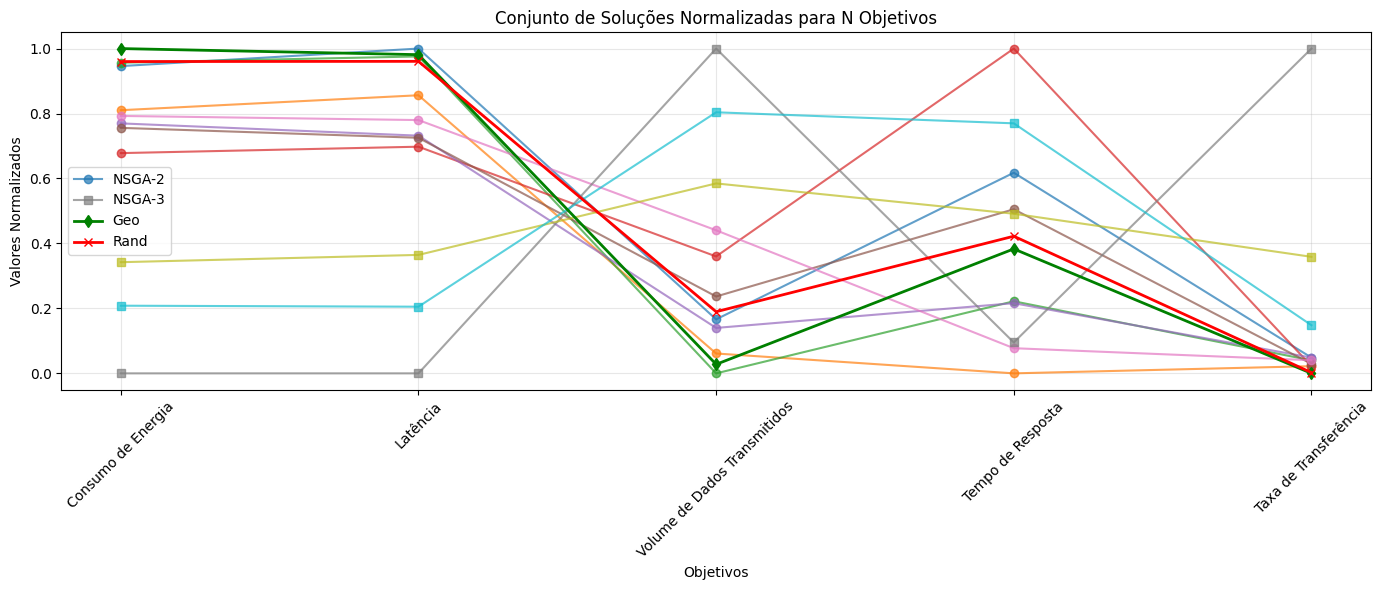

In [18]:
geo = [
    network_geo.total_energy_consumption,
    network_geo.total_latency,
    network_geo.total_data_transmitted,
    network_geo.total_response_time,
    network_geo.total_throughput,
]
rand = [
    network_rand.total_energy_consumption,
    network_rand.total_latency,
    network_rand.total_data_transmitted,
    network_rand.total_response_time,
    network_rand.total_throughput,
]
plot_solutions2(df2, df3, geo, rand)

#### Comparação com todos conectados à raiz

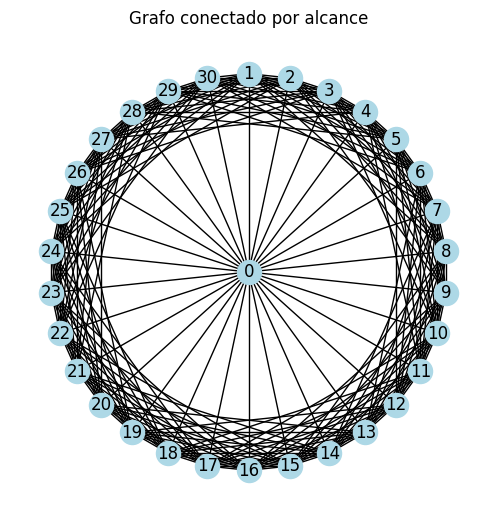

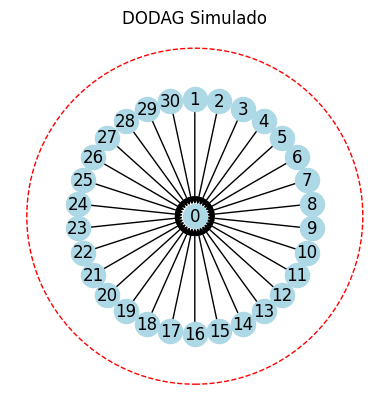

Consumo total de energia: 22.831429282987706
Latência total da rede: 2145.6811207379487
Volume total de dados transmitidos: 849.7687402518746
Tempo total de resposta: 2.171398770791459
Taxa total de transferência: 0.20121310996835562


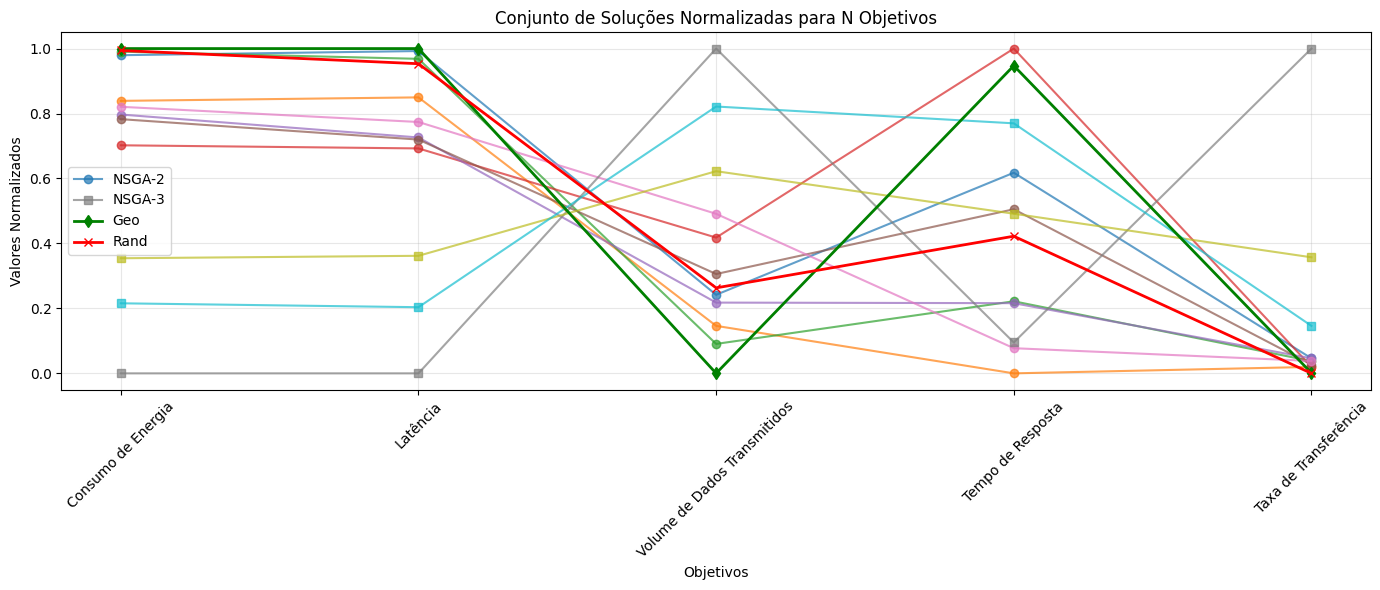

In [21]:
k = 0.7 * RADIUS_OF_REACH
theta = 2 * math.pi / (NUM_NODES - 1)  
generated_points = generate_positions(k, theta, NUM_NODES)

# Criação e simulação da rede
network_geo = Network(NUM_NODES, AREA_SIZE, RADIUS_OF_REACH, enable_plot=True)
network_geo.create_network(positions=generated_points)
network_geo.propagate_dio()
network_geo.visualize()

# Exibe métricas globais da rede
print("Consumo total de energia:", network_geo.total_energy_consumption)
print("Latência total da rede:", network_geo.total_latency)
print("Volume total de dados transmitidos:", network_geo.total_data_transmitted)
print("Tempo total de resposta:", network_geo.total_response_time)
print("Taxa total de transferência:", network_geo.total_throughput)

geo = [
    network_geo.total_energy_consumption,
    network_geo.total_latency,
    network_geo.total_data_transmitted,
    network_geo.total_response_time,
    network_geo.total_throughput,
]
plot_solutions2(df2, df3, geo, rand)

#### Tentativa de uso do modelo de Barabasi-Albert

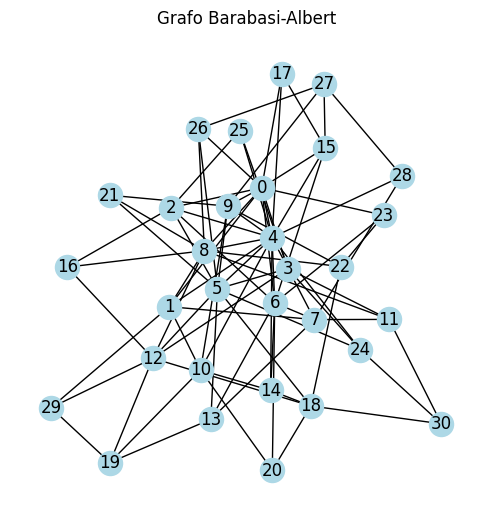

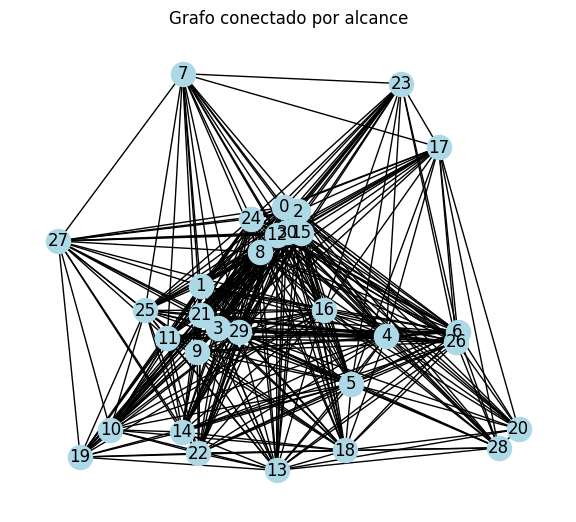

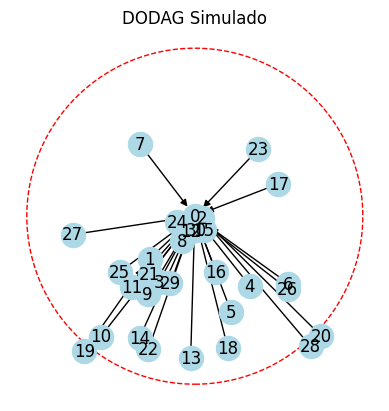

Consumo total de energia: 17.867360097509717
Latência total da rede: 1596.348975169417
Volume total de dados transmitidos: 881.1000103770833
Tempo total de resposta: 2.0458936273280552
Taxa total de transferência: 0.5354115002149905


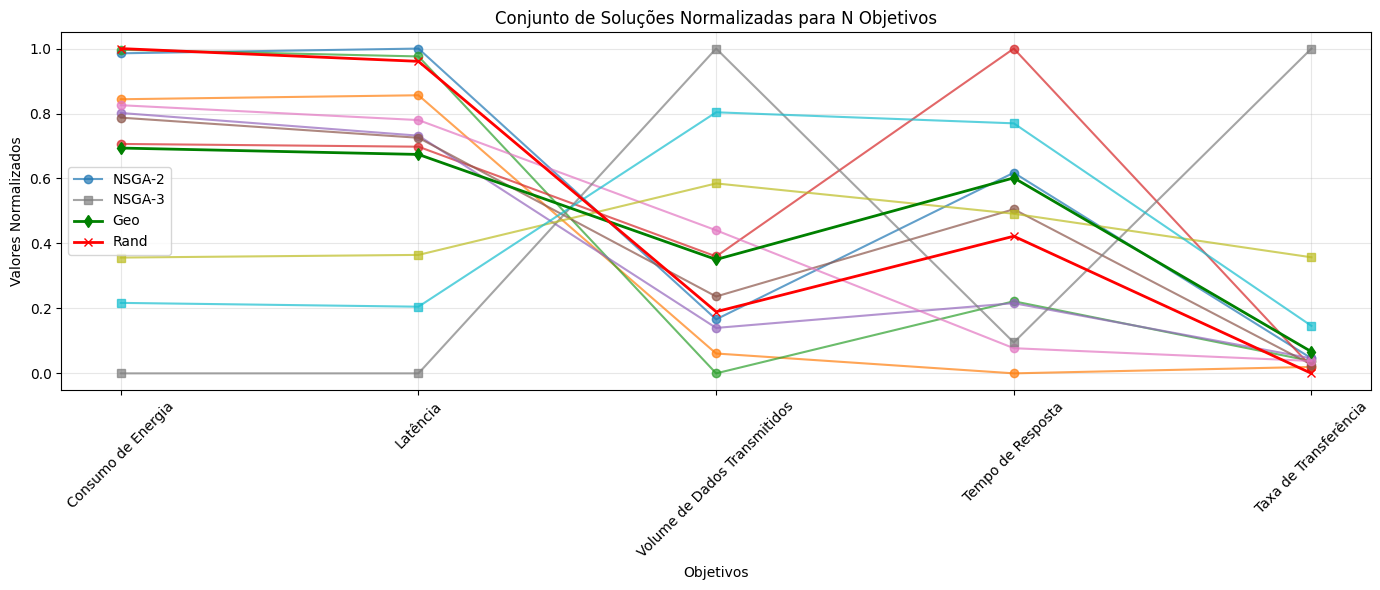

In [20]:
import math
import random
import networkx as nx

def generate_positions_barabasi_albert_bfs(n, m, radius, seed=None):
    """
    Gera um grafo pelo modelo Barabási-Albert (com n nós e m arestas anexadas
    a cada novo nó). Em seguida, realiza um posicionamento partindo do nó 0 
    (considerado 'raiz'), colocando cada vizinho dentro de um círculo de raio 
    'raio' centrado na posição do pai.

    Parâmetros:
        n (int): Número de nós do grafo.
        m (int): Número de arestas criadas a cada novo nó no modelo Barabási-Albert.
        raio (float): Raio de alcance que delimita onde os filhos podem ser posicionados
                      em relação ao pai.
        seed (int, optional): Semente para o gerador de números aleatórios (reprodutibilidade).

    Retorna:
        (G, positions): 
            G -> Grafo Barabási-Albert gerado (networkx.Graph).
            positions -> dicionário {node_id: (x, y)} com coordenadas dos nós.
    """
    if seed is not None:
        random.seed(seed)

    # 1) Cria o grafo Barabási–Albert
    G = nx.barabasi_albert_graph(n, m, seed=seed)

    # 2) Dicionário para armazenar as posições dos nós
    #    Vamos considerar o nó 0 como raiz e colocá-lo em (0, 0).
    positions = {0: (0.0, 0.0)}

    # 3) Realiza uma busca em largura (BFS) começando de 0
    visited = set([0])
    queue = [0]

    while queue:
        parent = queue.pop(0)

        # Para cada vizinho do 'parent', se ainda não foi visitado:
        for child in G[parent]:
            if child not in visited:
                visited.add(child)
                queue.append(child)

                # Sorteia uma posição (x, y) dentro de um círculo de raio 'raio'
                # centrado no pai.                
                px, py = positions[parent]

                # Geração de ponto aleatório uniforme em um círculo de raio 'raio'
                # Para distribuição uniforme em área, o raio real é raio * sqrt(r).
                r = math.sqrt(random.random()) * radius
                theta = 2 * math.pi * random.random()

                x = px + r * math.cos(theta)
                y = py + r * math.sin(theta)

                positions[child] = (x, y)

    return G, [positions[node] for node in sorted(positions.keys())]


G, generated_points = generate_positions_barabasi_albert_bfs(NUM_NODES, 3, 0.75 * RADIUS_OF_REACH)

generated_points = adjust_dodag(generated_points, RADIUS_OF_REACH)

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=300, node_color='lightblue')
plt.gca().set_aspect("equal", adjustable="box")
plt.title("Grafo Barabasi-Albert")
plt.show()

# Criação e simulação da rede
network_geo = Network(NUM_NODES, AREA_SIZE, RADIUS_OF_REACH, enable_plot=True)
network_geo.create_network(positions=generated_points)
network_geo.propagate_dio()
network_geo.visualize()

# Exibe métricas globais da rede
print("Consumo total de energia:", network_geo.total_energy_consumption)
print("Latência total da rede:", network_geo.total_latency)
print("Volume total de dados transmitidos:", network_geo.total_data_transmitted)
print("Tempo total de resposta:", network_geo.total_response_time)
print("Taxa total de transferência:", network_geo.total_throughput)

geo = [
    network_geo.total_energy_consumption,
    network_geo.total_latency,
    network_geo.total_data_transmitted,
    network_geo.total_response_time,
    network_geo.total_throughput,
]
plot_solutions2(df2, df3, geo, rand)
